In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from env import user, password, host
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import levene, ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import math
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
#read in the csv
diabetes_df = pd.read_csv('diabetes.csv')

In [3]:
#get a quick look at the df
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# Initital Thoughts
#### The data frame is a collection of medical measurements that directly influence whether or not a person has diabetes.  Domain background knowledge helps with this df.  The more pregnancies, the higher probability you will have gestastional diabetes that may resolve after pregnancy.  Glucose measurements below 99 may indicate that you are not diabetic, but prediabetic.  If you have diabetes, it strains your kidneys, which makes your blood pressure rise.  A physical symptom of diabetics is thickening of the skin around the neck and it darkens it, too. The insulin measurement indicates how much insulin is in your blood test and higher the number the higher the chance of diabetes..  The same with BMI, high is bad,  The Diabetes Pedigree Function is a function which scores likelihood of diabetes based on family history, so higher numbers indicate that you may more predisposed to diabetes.

### Exploring this df will help us  to see which of the measurement has a high(or higher) correlation to the outcome.

### H0- The target variable, outcome,  has no exact or actual relationship between the variables.

### Ha- The target variable, outcome, has a relationship between the variables

In [4]:
#see shape (rows and columns), column names, non null counts and datat types
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# looks at math stats
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# used to copy the lower case column names for the renaming of columns
diabetes_df.columns.str.lower()

Index(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin',
       'bmi', 'diabetespedigreefunction', 'age', 'outcome'],
      dtype='object')

In [7]:
# rename lower case and insert _ for separation of words in column names for better readability and easy manipulations of columns
diabetes_df=diabetes_df.rename(columns={'Pregnancies': 'pregnancies',
                          'Glucose':'glucose',
                          'BloodPressure':'blood_pressure',
                          'SkinThickness':'skin_thickness',
                          'Insulin':'insulin',
                          'BMI':'bmi',
                          'DiabetesPedigreeFunction': 'diabetes_pedigree_function',
                          'Age':'age',
                          'Outcome': 'outcome',
                          })

In [8]:
# making sure they are now renamed
diabetes_df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### checking for outliers

In [9]:
numeric_col = ['pregnancies','glucose','blood_pressure','skin_thickness','insulin','bmi','diabetes_pedigree_function','age']

<AxesSubplot:>

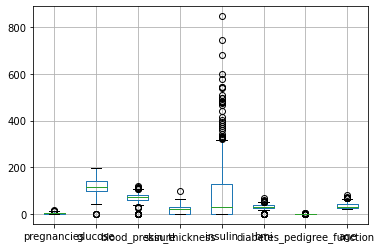

In [10]:
diabetes_df.boxplot(numeric_col)

<AxesSubplot:xlabel='pregnancies'>

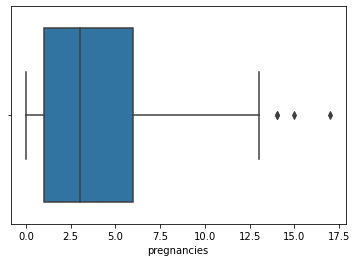

In [11]:
sns.boxplot(x = 'pregnancies', data = diabetes_df)

<AxesSubplot:xlabel='glucose'>

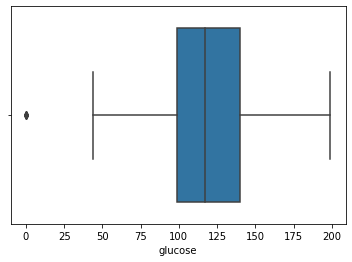

In [12]:
sns.boxplot(x = 'glucose', data = diabetes_df)

<AxesSubplot:xlabel='blood_pressure'>

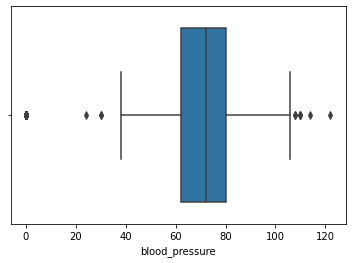

In [13]:
sns.boxplot(x = 'blood_pressure', data = diabetes_df)

<AxesSubplot:xlabel='skin_thickness'>

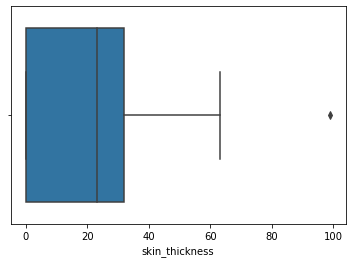

In [14]:
sns.boxplot(x = 'skin_thickness', data = diabetes_df)

<AxesSubplot:xlabel='insulin'>

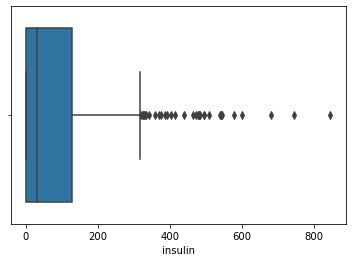

In [15]:
sns.boxplot(x = 'insulin', data = diabetes_df)

<AxesSubplot:xlabel='bmi'>

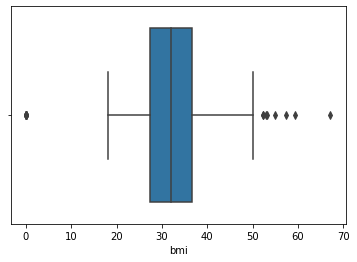

In [16]:
sns.boxplot(x = 'bmi', data = diabetes_df)

<AxesSubplot:xlabel='diabetes_pedigree_function'>

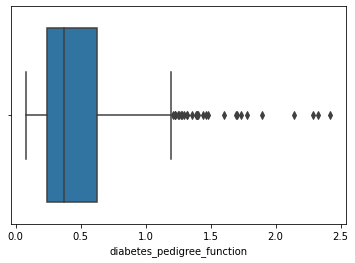

In [17]:
sns.boxplot(x = 'diabetes_pedigree_function', data = diabetes_df)

<AxesSubplot:xlabel='age'>

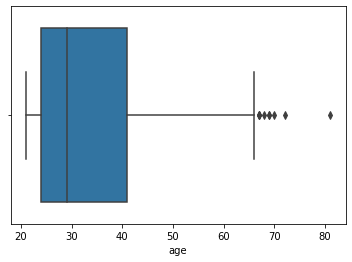

In [18]:
sns.boxplot(x = 'age', data = diabetes_df)

In [19]:
for x in ['pregnancies']:
    q75,q25 = np.percentile(diabetes_df.loc[:,x],[75,25])
    IQR = q75-q25
 
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
 
    diabetes_df.loc[diabetes_df[x] < min,x] = np.nan
    diabetes_df.loc[diabetes_df[x] > max,x] = np.nan

In [20]:
for x in ['glucose']:
    q75,q25 = np.percentile(diabetes_df.loc[:,x],[75,25])
    IQR = q75-q25
 
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
 
    diabetes_df.loc[diabetes_df[x] < min,x] = np.nan
    diabetes_df.loc[diabetes_df[x] > max,x] = np.nan

In [21]:
for x in ['blood_pressure']:
    q75,q25 = np.percentile(diabetes_df.loc[:,x],[75,25])
    IQR = q75-q25
 
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
 
    diabetes_df.loc[diabetes_df[x] < min,x] = np.nan
    diabetes_df.loc[diabetes_df[x] > max,x] = np.nan

In [22]:
for x in ['skin_thickness']:
    q75,q25 = np.percentile(diabetes_df.loc[:,x],[75,25])
    IQR = q75-q25
 
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
 
    diabetes_df.loc[diabetes_df[x] < min,x] = np.nan
    diabetes_df.loc[diabetes_df[x] > max,x] = np.nan

In [23]:
for x in ['insulin']:
    q75,q25 = np.percentile(diabetes_df.loc[:,x],[75,25])
    IQR = q75-q25
 
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
 
    diabetes_df.loc[diabetes_df[x] < min,x] = np.nan
    diabetes_df.loc[diabetes_df[x] > max,x] = np.nan

In [24]:
for x in ['bmi']:
    q75,q25 = np.percentile(diabetes_df.loc[:,x],[75,25])
    IQR = q75-q25
 
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
 
    diabetes_df.loc[diabetes_df[x] < min,x] = np.nan
    diabetes_df.loc[diabetes_df[x] > max,x] = np.nan

In [25]:
for x in ['diabetes_pedigree_function']:
    q75,q25 = np.percentile(diabetes_df.loc[:,x],[75,25])
    IQR = q75-q25
 
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
 
    diabetes_df.loc[diabetes_df[x] < min,x] = np.nan
    diabetes_df.loc[diabetes_df[x] > max,x] = np.nan

In [26]:
for x in ['age']:
    q75,q25 = np.percentile(diabetes_df.loc[:,x],[75,25])
    IQR = q75-q25
 
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
 
    diabetes_df.loc[diabetes_df[x] < min,x] = np.nan
    diabetes_df.loc[diabetes_df[x] > max,x] = np.nan

In [27]:
diabetes_df.isnull().sum()

pregnancies                    4
glucose                        5
blood_pressure                45
skin_thickness                 1
insulin                       34
bmi                           19
diabetes_pedigree_function    29
age                            9
outcome                        0
dtype: int64

In [28]:
diabetes_df = diabetes_df.dropna(axis = 0)

In [29]:
diabetes_df.isnull().sum()

pregnancies                   0
glucose                       0
blood_pressure                0
skin_thickness                0
insulin                       0
bmi                           0
diabetes_pedigree_function    0
age                           0
outcome                       0
dtype: int64

In [30]:
'pregnancies','glucose','blood_pressure','skin_thickness','insulin','bmi','diabetes_pedigree_function','age'

('pregnancies',
 'glucose',
 'blood_pressure',
 'skin_thickness',
 'insulin',
 'bmi',
 'diabetes_pedigree_function',
 'age')

# Let's visualize the data

array([[<AxesSubplot:title={'center':'pregnancies'}>,
        <AxesSubplot:title={'center':'glucose'}>,
        <AxesSubplot:title={'center':'blood_pressure'}>],
       [<AxesSubplot:title={'center':'skin_thickness'}>,
        <AxesSubplot:title={'center':'insulin'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'diabetes_pedigree_function'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'outcome'}>]], dtype=object)

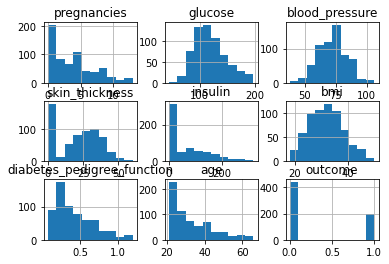

In [31]:
# use pandas hist()
diabetes_df.hist()

# univarate analysis

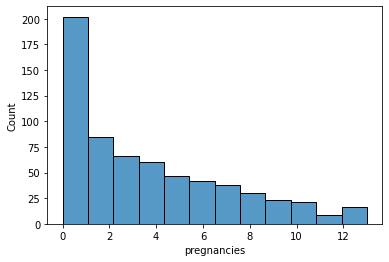

In [32]:
# using seaborn, create basic histograms for each column
sns.histplot(data=diabetes_df, x="pregnancies")
plt.show()

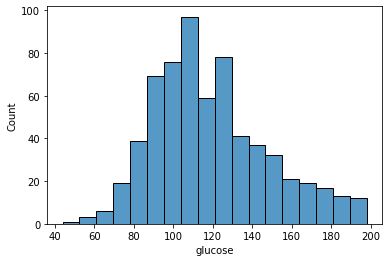

In [33]:
sns.histplot(data=diabetes_df, x="glucose")
plt.show()

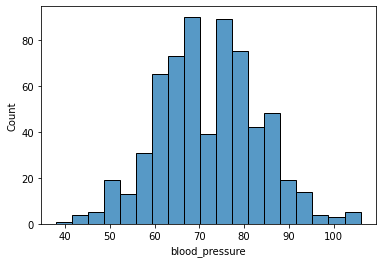

In [34]:
sns.histplot(data=diabetes_df, x="blood_pressure")
plt.show()

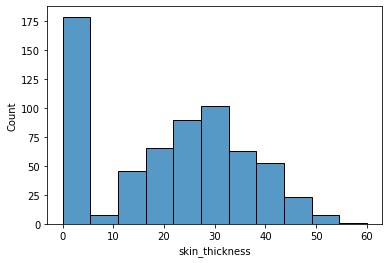

In [35]:
sns.histplot(data=diabetes_df, x="skin_thickness")
plt.show()

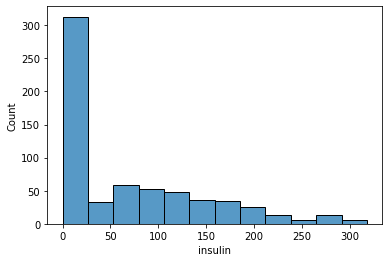

In [36]:
sns.histplot(data=diabetes_df, x="insulin")
plt.show()

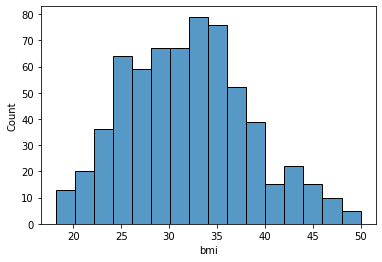

In [37]:
sns.histplot(data=diabetes_df, x="bmi")
plt.show()

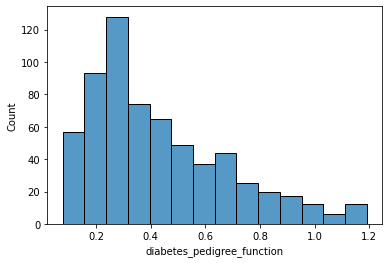

In [38]:
sns.histplot(data=diabetes_df, x="diabetes_pedigree_function")
plt.show()

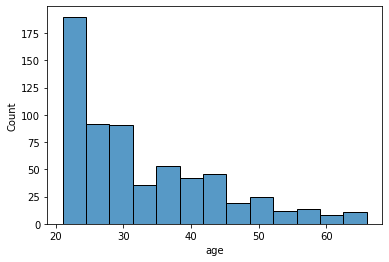

In [39]:
sns.histplot(data=diabetes_df, x="age")
plt.show()

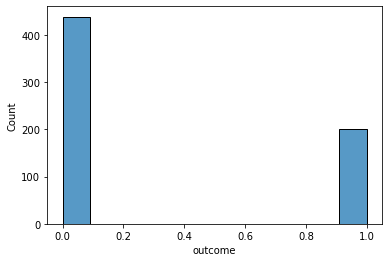

In [40]:
sns.histplot(data=diabetes_df, x="outcome")
plt.show()

# bivariate analysis, comparing to columns to eachother

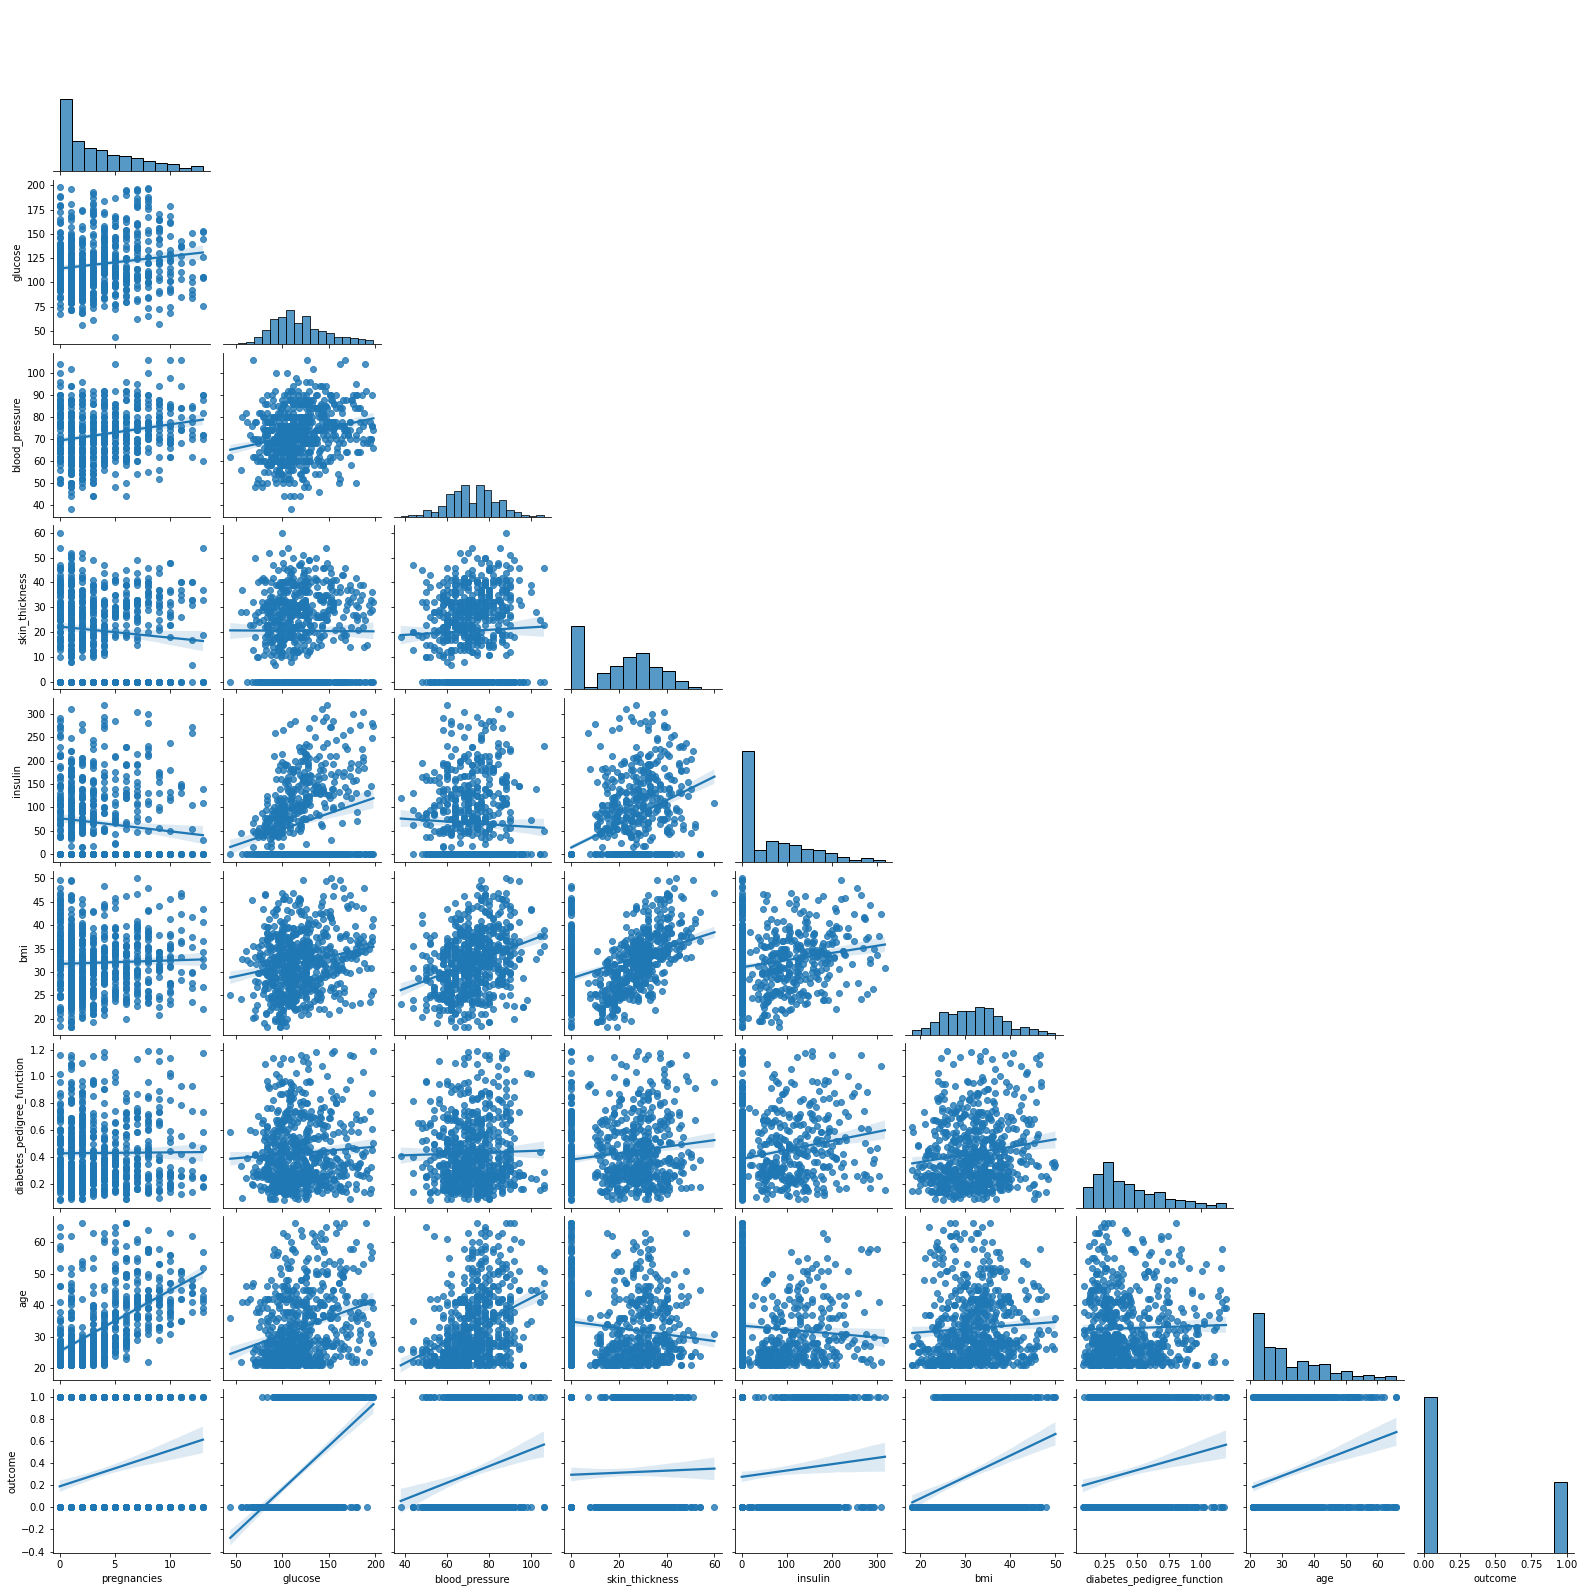

In [41]:
sns.pairplot(data=diabetes_df, kind="reg", corner=True)

In [42]:
spearman_corr= diabetes_df.corr(method='spearman')
spearman_corr

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
pregnancies,1.000000,0.145390,0.180121,-0.092378,-0.157094,0.015742,-0.029413,0.614876,0.220305
glucose,0.145390,1.000000,0.256952,0.011370,0.165226,0.175495,0.050965,0.282035,0.467279
blood_pressure,0.180121,0.256952,1.000000,0.057768,-0.071614,0.304682,0.008288,0.380873,0.182140
skin_thickness,-0.092378,0.011370,0.057768,1.000000,0.507693,0.436470,0.151771,-0.072367,0.057677
insulin,-0.157094,0.165226,-0.071614,0.507693,1.000000,0.163782,0.231063,-0.123858,0.043900
bmi,0.015742,0.175495,0.304682,0.436470,0.163782,1.000000,0.134978,0.137051,0.267286
diabetes_pedigree_function,-0.029413,0.050965,0.008288,0.151771,0.231063,0.134978,1.000000,0.015223,0.174183
age,0.614876,0.282035,0.380873,-0.072367,-0.123858,0.137051,0.015223,1.000000,0.317514
outcome,0.220305,0.467279,0.182140,0.057677,0.043900,0.267286,0.174183,0.317514,1.000000


### The .corr() method allowed me to not only see what correlates with the target variable, but how they correlate with each other. It appears that both insulin and bmi,  have a relationship with skin_thickness. It appears that pregnancies and blood pressure have a correlating factor with age. Glucose has the highest correlation with outcome.

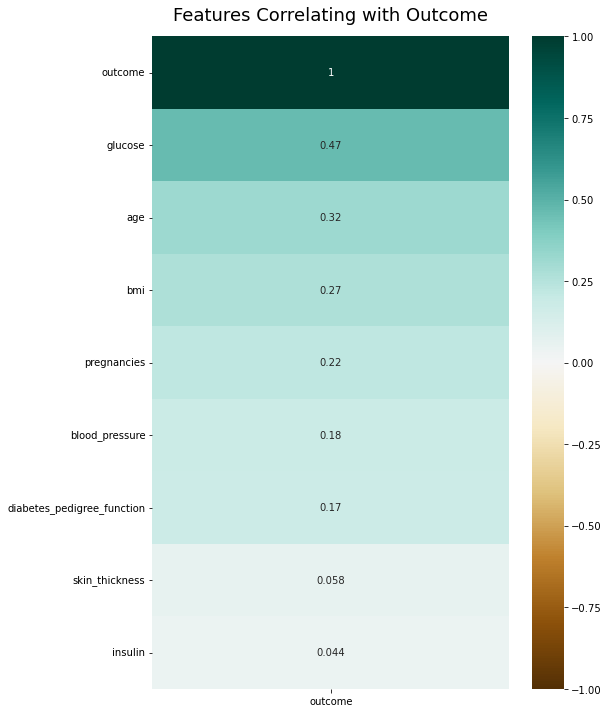

In [43]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(diabetes_df.corr(method='spearman')[['outcome']].sort_values(by='outcome', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Outcome', fontdict={'fontsize':18}, pad=16);

### The heatmap allowed me to see what correlates with the target variable, outcome. Glucose is highly correleated with outcome.

In [44]:
# Use a scipy stats function spearmanr to calculate the correlation coefficient and the p-value.
def spearman_test(df, target_var, test_var):
    r, p_value = spearmanr(diabetes_df[target_var], diabetes_df[test_var])
    print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

In [45]:
spearman_test(diabetes_df, 'outcome', 'pregnancies')

Correlation Coefficient: 0.2203046202636451
P-value: 1.8301350556916528e-08


In [46]:
spearman_test(diabetes_df, 'outcome', 'glucose')

Correlation Coefficient: 0.46727899388484134
P-value: 5.652128117825285e-36


In [47]:
spearman_test(diabetes_df, 'outcome', 'blood_pressure')

Correlation Coefficient: 0.18214034048457312
P-value: 3.5861871160692656e-06


In [48]:
spearman_test(diabetes_df, 'outcome', 'skin_thickness')

Correlation Coefficient: 0.05767689930750988
P-value: 0.14529853222595943


In [49]:
spearman_test(diabetes_df, 'outcome', 'insulin')

Correlation Coefficient: 0.04389960653216781
P-value: 0.26782923044193147


In [50]:
spearman_test(diabetes_df, 'outcome', 'bmi')

Correlation Coefficient: 0.26728635645902016
P-value: 6.478528335084564e-12


In [51]:
spearman_test(diabetes_df, 'outcome', 'diabetes_pedigree_function')

Correlation Coefficient: 0.17418259383385748
P-value: 9.496112987728098e-06


In [52]:
spearman_test(diabetes_df, 'outcome', 'age')

Correlation Coefficient: 0.317513825451993
P-value: 1.963324080843468e-16


#### from a website, I found this explanation: correlation refers to the strength and direction of a relationship between two variables. The value of a correlation coefficient can range from -1 to 1, with the following interpretations:

#### -1: a perfect negative relationship between two variables
#### 0: no relationship between two variables
#### 1: a perfect positive relationship between two variables

#### And on the p-value: A p-value close to 1 suggests no correlation other than due to chance and that your null hypothesis assumption is correct. If your p-value is close to 0, the observed correlation is unlikely to be due to chance and there is a very high probability that your null hypothesis is wrong.